In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from helpers import helpfunction as helper

In [14]:
# This cell is a single event viewer!
def SingleEventViewer(run,subrun,event, sample_dict, save_plot=False):
    nrPMT = 32
    rangePMT = range(nrPMT)
    gr = (1+np.sqrt(5))/2
    
    str_pause = '------------------------------'
    event_keys = ['nFlashes', 'hasBeamFlash', 'nSlices', 'nSlicesAfterPrecuts', 'foundATargetSlice', 
                  'nuCCNC', 'nuEnergy', 'leptonEnergy', 'nuInteractionTime', 'nuPdgCode', 'nuVertexX', 'nuVertexY', 'nuVertexZ']
    flash_keys = ['time', 'centerY', 'centerZ', 'widthY', 'widthZ', 'totalPE', 'inBeamWindow', 'isBeamFlash']
    slice_keys = ['hasDeposition', 'totalCharge', 'centerX', 'centerY', 'centerZ', 'nHits',
                  'deltaY', 'deltaZ', 'deltaYSigma', 'deltaZSigma', 'chargeToLightRatio', 
                  'passesPreCuts', 'flashMatchScore', 'totalPEHypothesis', 
                  'isTaggedAsTarget', 'isConsideredByFlashId', 'topologicalScore', 'hasBestTopologicalScore', 
                  'purity', 'completeness']
    # Event Info:
    event_dict = sample_dict['events']
    events_index = np.where( (event_dict['run']==run) & (event_dict['subRun']==subrun) & (event_dict['event']==event) ) 
    if len(events_index[0])!=1:
        print('The combination of event, subrun and run was found '+str(len(events_index[0]))+" times in the sample.")
        if len(events_index[0])>1:
            print("Taking the first one...\n")
        else:
            return
    print('Run',run,', Subrun', subrun,', Event',event,' found!','\n',str_pause)
    print('\n--- EVENT INFO ---')
    events_index = events_index[0][0]
    event_time = event_dict['evt_time_sec'][events_index]
    for key in event_keys:
        print(key, ':\t', event_dict[key][events_index])
        
    # Flash Info:
    flash_dict = sample_dict['flashes']
    flashes_indices = np.where( (flash_dict['evt_time_sec']==event_time) & (flash_dict['run']==run) & (flash_dict['subRun']==subrun) & (flash_dict['event']==event))[0]
    print('\n--- FLASH INFO ---')
    for key in flash_keys:
        print(key, ':\t', flash_dict[key][flashes_indices])
    
    # Slice Info:
    slice_dict = sample_dict['slices']
    slices_indices = np.where( (slice_dict['evt_time_sec']==event_time) & (slice_dict['run']==run) & (slice_dict['subRun']==subrun) & (slice_dict['event']==event))[0]
    print('\n--- SLICE INFO ---')
    for key in slice_keys:
        print(key, ':\t', slice_dict[key][slices_indices])
    
    if not np.any(flash_dict['isBeamFlash'][flashes_indices]):
        print('\nUnable to plot: There was no beamflash in the selected event!')
        return
    # Make the plot!
    fig, ax = plt.subplots(figsize=(6*gr,5.5))
    ax.set_xlabel('PMT identification number')
    ax.set_ylabel('Number of Photo-electrons per PMT')
    ax.grid(alpha=.3)
    
    beam_flash_index = flashes_indices[flash_dict['isBeamFlash'][flashes_indices]][0]
    beam_flash_pe = flash_dict['peSpectrum'][beam_flash_index]
    
    lab_flash = "Optical Flash\n  PE: {0:.0f} \n  ".format(flash_dict['totalPE'][beam_flash_index]) \
                +r"$z$: {0:.0f} cm".format(flash_dict['centerZ'][beam_flash_index])
    
    ax.errorbar(rangePMT,beam_flash_pe, yerr=np.sqrt(beam_flash_pe), fmt="none")
    ax.fill_between(rangePMT, beam_flash_pe, alpha=.5,label=lab_flash)
    
    
    #slice_hypo_index = slices_indices[slice_dict['passesPreCuts][slices_indices]]
    slice_hypo_index = slices_indices[slice_dict['isConsideredByFlashId'][slices_indices]]
    flash_hypo_pe = slice_dict['peHypothesisSpectrum'][slice_hypo_index]
    for i,(idx, spectrum) in enumerate(zip(slice_hypo_index, flash_hypo_pe)):
        slice_lab = '\nSlice Hypothesis '+str(i)+"\n  "
        slice_lab+=r"Purity: "+ str(round(slice_dict['purity'][idx],1)) + ",  "
        slice_lab+=r"Completeness: "+ str(round(slice_dict['completeness'][idx],3)) + "\n  "
        slice_lab+=r"Topo score: "+ str(round(slice_dict['topologicalScore'][idx],3)) + "\n  "
        slice_lab+=r"Flash $\chi^2$: {0:.0f}".format(slice_dict['flashMatchScore'][idx])
        slice_lab+=", "+r"$\Delta$z: "+ str(round(slice_dict['deltaZ'][idx],1)) + "cm"
        if(len(spectrum)==nrPMT):
            ax.errorbar(rangePMT,spectrum, yerr= np.sqrt(spectrum), label=slice_lab) 

    ax.legend(bbox_to_anchor=(1.02,0.2,.25,.8),loc=2)
    
    ax.set_title('Run '+str(run)+', Subrun '+str(subrun)+', Event '+str(event), loc='left')
    if ('nuPdgCode' in event_dict.keys()):
        d_pdg = {12: r"$\nu_e$", 14: r"$\nu_\mu$",-12: r"$\bar{\nu_e}$", -14: r"$\bar{\nu_\mu}$"}
        print(str_pause,"\nProducing plot for MC event!")
        ax.set_title("MicroBooNE Simulation", loc='right')
        txt =  d_pdg[event_dict['nuPdgCode'][events_index]]
        txt+= " with {0:.2f} GeV energy\n".format(event_dict['nuEnergy'][events_index])
        txt+= "and vertex: ({0:.0f}, {1:.0f}, {2:.0f}) cm".format(event_dict['nuVertexX'][events_index],
                                     event_dict['nuVertexY'][events_index],
                                     event_dict['nuVertexZ'][events_index])
        x_txt_start = 1
        if np.argmax(beam_flash_pe)<nrPMT/2:
            x_txt_start = 16
        
        ax.text(x_txt_start, 0.85*ax.get_ylim()[1], txt, fontsize=12)
        ax.set_ylim(0,ax.get_ylim()[1])
        ax.set_xlim(-0.5,31.5)
    else:
        print(str_pause,"\nProducing plot for Data event!")
        ax.set_title("MicroBooNE Data", loc='right')
        
    fig.tight_layout()
    if save_plot:
        tag = "run"+str(run)+"_subrun"+str(subrun)+"_event"+str(event)
        fig.savefig(outdir+"event_viewer_"+tag+".pdf", bbox_inches="tight")
        print("Image saved: "+outdir+"event_viewer_"+tag+".pdf" )
    return fig

In [15]:
def singe_event_viewer(sequence, sample_dict, save_plot=False):
    run =file_dict['events']['run'][sequence]
    subRun =file_dict['events']['subRun'][sequence]
    event =file_dict['events']['event'][sequence]
    return SingleEventViewer(run,subRun,event, sample_dict, save_plot)

### Make the actual plots

In [4]:
data = False
run_set = 1
sample = 'nue'

In [5]:
indir = "./input/Jan2020/pickled/"
outdir = "./output/neutrinoID/single_event_viewer/"

In [6]:
if data:
    kind = 'data'
else:
    kind='mc'
in_file = open(indir + "{}_run{}.pckl".format(kind,run_set), "rb")
file_dict = pickle.load(in_file)[sample]
in_file.close()

Run 6813 , Subrun 230 , Event 11514  found! 
 ------------------------------

--- EVENT INFO ---
nFlashes :	 1
hasBeamFlash :	 True
nSlices :	 3
nSlicesAfterPrecuts :	 2
foundATargetSlice :	 True
nuCCNC :	 0
nuEnergy :	 1.17073
leptonEnergy :	 0.61600953
nuInteractionTime :	 3537.6787
nuPdgCode :	 12
nuVertexX :	 241.64607
nuVertexY :	 -89.05831
nuVertexZ :	 316.9918

--- FLASH INFO ---
time :	 [4.00625]
centerY :	 [-6.900504]
centerZ :	 [356.92624]
widthY :	 [45.577957]
widthZ :	 [175.76646]
totalPE :	 [197.05566]
inBeamWindow :	 [ True]
isBeamFlash :	 [ True]

--- SLICE INFO ---
hasDeposition :	 [ True  True  True]
totalCharge :	 [31607.549 20060.57   3285.4  ]
centerX :	 [ 94.20494 230.22115 149.28392]
centerY :	 [ 78.031784 -92.146835  62.007645]
centerZ :	 [442.97418 334.99966 389.60992]
nHits :	 [828 374  85]
deltaY :	 [ 84.93229 -85.24633  68.90815]
deltaZ :	 [ 86.04794  -21.926575  32.683685]
deltaYSigma :	 [ 1.863451  -1.8703412  1.5118744]
deltaZSigma :	 [ 0.48955837 -0.12474

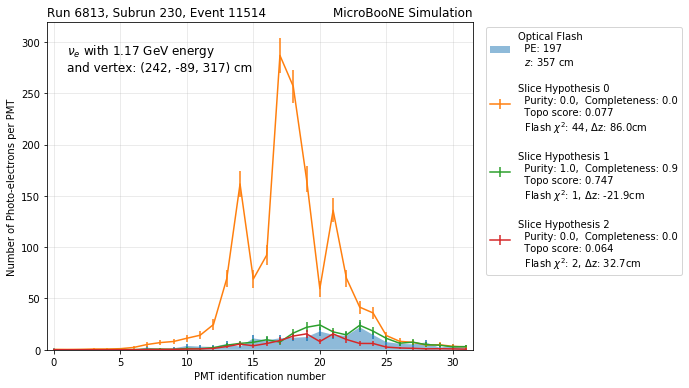

In [11]:
#5
_ = singe_event_viewer(4, file_dict, save_plot=True)

In [8]:
slices4 = file_dict['events']['nSlices']==4
foundATargetSlice = file_dict['events']['foundATargetSlice']==True
suggestions = np.where(slices4 & foundATargetSlice)[0]

In [ ]:
for seq in suggestions:
    print(seq)
    fig = singe_event_viewer(seq, file_dict, save_plot=True)
    input(" Press Enter to continue...")

5
Run 6813 , Subrun 230 , Event 11515  found! 
 ------------------------------

--- EVENT INFO ---
nFlashes :	 2
hasBeamFlash :	 True
nSlices :	 4
nSlicesAfterPrecuts :	 2
foundATargetSlice :	 True
nuCCNC :	 0
nuEnergy :	 4.0831084
leptonEnergy :	 3.9219308
nuInteractionTime :	 3361.9558
nuPdgCode :	 12
nuVertexX :	 154.87572
nuVertexY :	 -62.689976
nuVertexZ :	 652.8305

--- FLASH INFO ---
time :	 [ 3.841875 19.591875]
centerY :	 [ -6.7534966 -54.581345 ]
centerZ :	 [704.54504 861.6735 ]
widthY :	 [44.884712  9.473362]
widthZ :	 [141.69014 184.9695 ]
totalPE :	 [6637.9863   161.27007]
inBeamWindow :	 [ True False]
isBeamFlash :	 [ True False]

--- SLICE INFO ---
hasDeposition :	 [ True  True  True  True]
totalCharge :	 [172856.5    79544.06   24528.246  17357.799]
centerX :	 [165.36311   158.02817    34.43801     4.9674654]
centerY :	 [-58.07135   60.317997  33.204014  43.091145]
centerZ :	 [698.7207  926.98755 700.46375 283.02316]
nHits :	 [3733 1998  906  521]
deltaY :	 [-51.317852 

Image saved: ./output/neutrinoID/single_event_viewer/event_viewer_run7378_subrun96_event4831.pdf
 Press Enter to continue...
32
Run 7378 , Subrun 99 , Event 4981  found! 
 ------------------------------

--- EVENT INFO ---
nFlashes :	 1
hasBeamFlash :	 True
nSlices :	 4
nSlicesAfterPrecuts :	 1
foundATargetSlice :	 True
nuCCNC :	 0
nuEnergy :	 2.7537785
leptonEnergy :	 2.499165
nuInteractionTime :	 4074.2485
nuPdgCode :	 12
nuVertexX :	 166.75253
nuVertexY :	 -91.48899
nuVertexZ :	 206.46478

--- FLASH INFO ---
time :	 [4.561875]
centerY :	 [-6.882797]
centerZ :	 [297.89188]
widthY :	 [44.274014]
widthZ :	 [147.45715]
totalPE :	 [3835.1028]
inBeamWindow :	 [ True]
isBeamFlash :	 [ True]

--- SLICE INFO ---
hasDeposition :	 [ True  True  True  True]
totalCharge :	 [102140.19   33544.773  78692.26    8370.897]
centerX :	 [174.57524 194.14499  84.80725 203.91742]
centerY :	 [-59.614395 -73.89139  -70.67913   84.1647  ]
centerZ :	 [ 282.80298  547.90546  169.03986 1020.5529 ]
nHits :	 [398

Image saved: ./output/neutrinoID/single_event_viewer/event_viewer_run7438_subrun14_event723.pdf
 Press Enter to continue...
73
Run 7079 , Subrun 75 , Event 3766  found! 
 ------------------------------

--- EVENT INFO ---
nFlashes :	 1
hasBeamFlash :	 True
nSlices :	 4
nSlicesAfterPrecuts :	 1
foundATargetSlice :	 True
nuCCNC :	 0
nuEnergy :	 0.56020945
leptonEnergy :	 0.40301713
nuInteractionTime :	 3892.5522
nuPdgCode :	 12
nuVertexX :	 116.418045
nuVertexY :	 -82.45327
nuVertexZ :	 618.1474

--- FLASH INFO ---
time :	 [4.36625]
centerY :	 [-12.9637575]
centerZ :	 [627.52625]
widthY :	 [42.493557]
widthZ :	 [139.19322]
totalPE :	 [1514.9103]
inBeamWindow :	 [ True]
isBeamFlash :	 [ True]

--- SLICE INFO ---
hasDeposition :	 [ True  True  True  True]
totalCharge :	 [26308.318 25100.291 17902.193 25812.025]
centerX :	 [164.05188  73.48196 221.38333 122.02409]
centerY :	 [ 69.62205   28.113407 -73.49065  -68.03238 ]
centerZ :	 [276.93866  420.12653   22.457928 626.7647  ]
nHits :	 [764 

Image saved: ./output/neutrinoID/single_event_viewer/event_viewer_run6337_subrun26_event1338.pdf
